# Classifying Idiopathic Parkinsons, Atypical Parkinsons (MSA & PSP), and Controls

Create a machine learning model to differentiate between 4 groups

## The Data


### Import Libraries and set random seed

In [2]:
import pandas as pd
import numpy as np
from sklearn.utils import resample
from sklearn import svm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

### Set Random Number Seed
np.random.seed(112)

### Define helper methods

In [3]:
def load_data(filename):
    data = pd.read_excel(filename)
    print("Loaded data with shape: ", data.shape)
    
    # Drop the subject column since its not used and contains non-numeric data
    return data.drop('Subject', axis=1)

In [4]:
def filter_data(data, columns=None, include_control=True, combine_p_groups=False):
    df = data.copy()
    
    if not include_control:
        df = df[df.GroupID!=0]
        
    if columns:
        df = df[columns]

    if combine_p_groups:
        df.loc[df['GroupID'] != 0, 'GroupID'] = 1 

    return df

In [5]:
def resample_data(df):
    df_control =df[df.GroupID==0]  #246
    df_park = df[df.GroupID==1] #399
    df_msa = df[df.GroupID==2]  #52
    df_psp = df[df.GroupID==3]  #55

    max_length = max([len(df_park), len(df_msa), len(df_psp), len(df_control)])

    if len(df_control) > 0:
        df_control = resample(df_control, replace=True, n_samples=max_length, random_state=3)
    if len(df_msa) > 0:
        df_msa = resample(df_msa, replace=True, n_samples=max_length, random_state=1)
    if len(df_psp) > 0:
        df_psp = resample(df_psp, replace=True, n_samples=max_length, random_state=2)

    return pd.concat([df_control, df_park, df_msa, df_psp])


In [6]:
def split_x_y_data(df, ylabel="GroupID"):
    x_cols = [col for col in df.columns if col != ylabel]
    Xd = pd.DataFrame(df, columns= x_cols)
    Yd = df[ylabel]
    return Xd, Yd

In [7]:
def standardize_data(X_train, X_test):
    sc = StandardScaler()
    sc.fit(X_train)
    X_train_std = sc.transform(X_train)
    X_test_std = sc.transform(X_test)
    return X_train_std, X_test_std

In [8]:
def svm_grid_search(X_train, X_test, y_train, y_test, cv=5):

    tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1, 1e-1, 1e-2,1e-3, 1e-4],
                         'C': [1, 10, 100, 1000]},
                        {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

    print("# Tuning hyper-parameters for f1")
    print()

    clf = GridSearchCV(svm.SVC(), tuned_parameters, cv=cv,
                       scoring='f1_macro',
                       n_jobs = -1 )
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()
    return clf

### Get Best SVM Model using all predictors

In [10]:
# Load the excel file
data = load_data("real_data2.xlsx")

# Only grab the columns of interest.  TODO: Replace with list derived from feature selection
columns_of_interest = ["GroupID","SCP_FW","MCP_FW","Putamen_FA","Caudate_FA","STN_FW", "RN_FW", "Thalamus_FA", "UPDRS"]
filtered_data = filter_data(data)

# Resample the data so that there are even numbers of each label
resampled_data = resample_data(filtered_data)

# Split predictor and response data
X, y = split_x_y_data(resampled_data)

# Shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

# standardize the data
X_train_std, X_test_std = standardize_data(X_train, X_test)

# Perform a grid search to find best SVC model
#clf = svm_grid_search(X_train, X_test, y_train, y_test)

Loaded data with shape:  (746, 39)


In [11]:

X_train.columns
d = pd.DataFrame(clf.best_estimator_.coef_, columns=X_train.columns)
i = {}
for c in d.columns:
    i[c] = sum(d[c]**2)
s = [(k, i[k]) for k in sorted(i, key=i.get, reverse=True)]
s

NameError: name 'clf' is not defined

## Feature Selection

### [Univariate feature selection](http://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection)  

In [12]:
data = load_data('real_data2.xlsx')

from sklearn.feature_selection import SelectKBest, chi2

X,y  = split_x_y_data(data)

cls = SelectKBest(chi2, k=2)
X_new = cls.fit_transform(X, y)

print(X.shape)
print(X_new.shape)
print(cls._get_param_names())

Loaded data with shape:  (746, 39)
(746, 37)
(746, 2)
['k', 'score_func']


### Recursive Feature Elimination with cross-validation

From [here](http://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html#sphx-glr-auto-examples-feature-selection-plot-rfe-with-cross-validation-py)

Needs the `coef_` or  `feature_importances_` attributes which the rbf kernal does not expose

Automatically created module for IPython interactive environment
Optimal number of features : 36


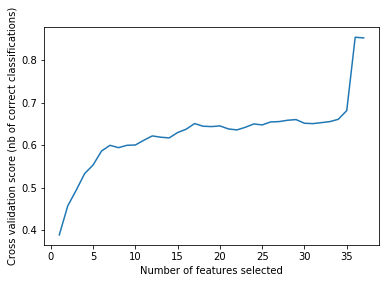

In [13]:
print(__doc__)

import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification

# Create the RFE object and compute a cross-validated score.
svc = SVC(kernel="linear", C=10)
# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(10),
              scoring='accuracy')
rfecv.fit(X_train, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

### Recursive Feature Elimination (without cross-validation)

From [here](http://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_digits.html#sphx-glr-auto-examples-feature-selection-plot-rfe-digits-py)

//Needs the `coef_` or  `feature_importances_` attributes which the rbf kernal does not expose

In [19]:
print(__doc__)

from sklearn.svm import SVC
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt


# Create the RFE object and rank each pixel
svc = SVC(kernel="linear", C=1)
rfe = RFE(estimator=svc, n_features_to_select=1, step=1)
rfe.fit(X_train, y_train)
#ranking = rfe.ranking_.reshape(X_train.shape)

# Plot pixel ranking
rfe.ranking_

Automatically created module for IPython interactive environment


array([37, 30, 36, 12, 15, 35, 21, 28, 31, 13,  5,  8, 33, 18, 26, 17, 22,
        9, 27, 34, 24, 29, 19, 10, 16,  3, 25,  2,  4,  1, 11, 20, 32,  7,
       23,  6, 14])